<a href="https://colab.research.google.com/github/choprahetarth/Spectral-Data-Prediction-TMLC/blob/main/Spectroscopy_Data_Analysis_and_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANN Based Spectral Data Analysis and Prediction
On the given dataset, following operations were performed to get an ideal MAPE of ~1.69.

- The dataset was loaded and EDA was performed, and it was ensured that multi-colinearity was removed.
- The dataset was normalized and trained on a baseline model scoring a MAPE of 5.9318.
- Using Keras Tuner, a hyper-parameter optimized model was trained, and using that, the final predictions provided a MAPE of 1.685780.

In [43]:
!pip install -q -U keras-tuner --quiet

In [44]:
#import libraries
# TODO - Remove Irrelevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import os 
import sys
import matplotlib.pyplot as plt
from pandas import plotting
import random
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split
from kerastuner.tuners import RandomSearch

SEED = 0

In [45]:
!nvidia-smi

Tue Aug 17 11:03:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    74W / 149W |    173MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [46]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [47]:
# change the working directory 
import os 
os.chdir('/content/drive/MyDrive/Colab Notebooks/TMLC Task')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/TMLC Task'

# Data EDA

In [48]:
df = pd.read_csv('NIR Data_V4_noperc_for_plot.csv')

In [49]:
# Display the first N rows
df.head()

,ContentUniformity,1110,1112,1114,1116,1118,1120,1122,1124,1126,1128,1130,1132,1134,1136,1138,1140,1142,1144,1146,1148,1150,1152,1154,1156,1158,1160,1162,1164,1166,1168,1170,1172,1174,1176,1178,1180,1182,1184,1186,...,1722,1724,1726,1728,1730,1732,1734,1736,1738,1740,1742,1744,1746,1748,1750,1752,1754,1756,1758,1760,1762,1764,1766,1768,1770,1772,1774,1776,1778,1780,1782,1784,1786,1788,1790,1792,1794,1796,1798,1800
0,100.1,2.659006,2.672815,2.694220,2.723126,2.760866,2.807864,2.862055,2.920742,2.981253,3.036830,3.087629,3.131265,3.166398,3.197083,3.225053,3.250675,3.275177,3.295606,3.312691,3.327062,3.340695,3.357744,3.380156,3.409389,3.444996,3.483318,3.522238,3.561105,3.596369,3.629168,3.660156,3.690679,3.726464,3.768926,3.818870,3.876354,3.933621,3.986120,4.027669,...,4.839038,4.806024,4.774920,4.737573,4.698571,4.662624,4.625348,4.584910,4.562636,4.537264,4.501718,4.462026,4.437594,4.411307,4.367460,4.335416,4.289590,4.282056,4.233408,4.235710,4.195461,4.169816,4.154829,4.118487,4.101122,4.095057,4.030425,4.028661,4.006373,3.988711,3.964631,3.954412,3.946111,3.911139,3.890765,3.865407,3.841028,3.903085,3.792994,3.794084
1,99.4,2.633610,2.647536,2.668880,2.697562,2.734915,2.781379,2.834928,2.892813,2.952398,3.007006,3.056853,3.099692,3.134243,3.164441,3.191953,3.217235,3.241383,3.261519,3.278479,3.292704,3.306256,3.323255,3.345500,3.374447,3.409581,3.447255,3.485452,3.523418,3.557921,3.589867,3.620058,3.650058,3.685089,3.726815,3.776105,3.832724,3.888908,3.940112,3.981189,...,4.815051,4.786598,4.733112,4.698572,4.668392,4.626639,4.605268,4.573858,4.546319,4.513479,4.469913,4.434455,4.403273,4.374036,4.336699,4.301046,4.279192,4.249538,4.224226,4.195281,4.176410,4.152728,4.106633,4.087850,4.075754,4.070809,4.011888,4.004490,3.976988,3.956921,3.950059,3.931803,3.919032,3.898129,3.881474,3.859406,3.831476,3.886848,3.784373,3.770951
2,100.7,2.692640,2.706064,2.727004,2.755307,2.792278,2.838367,2.891539,2.949106,3.008404,3.062823,3.112538,3.155178,3.189505,3.219527,3.246873,3.271984,3.295966,3.316024,3.332766,3.346776,3.360115,3.376754,3.398721,3.427305,3.462317,3.499965,3.538244,3.576388,3.610835,3.642965,3.673183,3.703098,3.738111,3.779806,3.828885,3.885635,3.941922,3.993384,4.033990,...,4.871758,4.834007,4.794460,4.761220,4.733205,4.699128,4.661964,4.623547,4.593665,4.559308,4.530856,4.482330,4.456696,4.419022,4.389550,4.363956,4.325943,4.295106,4.285052,4.252646,4.231442,4.188935,4.167522,4.153700,4.122859,4.120073,4.059996,4.047554,4.023197,4.012508,3.972120,3.959794,3.954294,3.927944,3.898880,3.903797,3.872811,3.923675,3.811084,3.817034
3,100.0,2.712384,2.727113,2.749633,2.779871,2.819207,2.868122,2.924739,2.986115,3.049603,3.107929,3.161397,3.207536,3.244820,3.277422,3.307086,3.334371,3.360511,3.382473,3.400919,3.416304,3.430761,3.448775,3.472255,3.502698,3.540101,3.580708,3.621978,3.663327,3.700763,3.735476,3.768060,3.800081,3.837236,3.881423,3.933309,3.993458,4.053665,4.108565,4.152332,...,4.950016,4.910472,4.846022,4.829983,4.797855,4.764687,4.730912,4.692926,4.666827,4.632955,4.595406,4.560094,4.532080,4.494218,4.465956,4.438041,4.396047,4.369446,4.338877,4.326460,4.302887,4.265118,4.241528,4.218702,4.197325,4.198031,4.132119,4.119234,4.111952,4.093168,4.077374,4.071253,4.080235,4.048216,4.039794,4.020414,3.997269,4.122222,3.958862,3.963222
4,99.7,2.588002,2.597217,2.612367,2.633553,2.661625,2.698152,2.741386,2.789405,2.841268,2.890166,2.935327,2.974604,3.006563,3.033907,3.058305,3.080267,3.101422,3.119017,3.133604,3.145648,3.156844,3.170602,3.188781,3.212536,3.242287,3.275069,3.308845,3.342907,3.373782,3.402214,3.428855,3.454876,3.485248,3.521466,3.564656,3.614966,3.665638,3.712346,3.750209,...,4.922612,4.884944,4.839852,4.813469,4.752826,4.738914,4.715207,4.666349,4.640165,4.603614,4.558908,4.529105,4.506724,4.484522,4.446957,4.396574,4.369641,4.350126,4.312047,4.301819,4.269893,4.237147,4.219388,4.191328,4.169955,4.146274,4.105875,4.092352,4.071337,4.052164,4.028621,4.020946,4.013075,3.974624,3.958395,3.931957,3.914

In [50]:
# Get the basic data statistics.
df.describe()

,ContentUniformity,1110,1112,1114,1116,1118,1120,1122,1124,1126,1128,1130,1132,1134,1136,1138,1140,1142,1144,1146,1148,1150,1152,1154,1156,1158,1160,1162,1164,1166,1168,1170,1172,1174,1176,1178,1180,1182,1184,1186,...,1722,1724,1726,1728,1730,1732,1734,1736,1738,1740,1742,1744,1746,1748,1750,1752,1754,1756,1758,1760,1762,1764,1766,1768,1770,1772,1774,1776,1778,1780,1782,1784,1786,1788,1790,1792,1794,1796,1798,1800
count,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,...,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000
mean,96.581714,2.716748,2.728888,2.748103,2.774431,2.808935,2.852225,2.902620,2.957320,3.014289,3.066998,3.115301,3.157184,3.191201,3.220901,3.248015,3.272811,3.296566,3.316481,3.333046,3.346905,3.359970,3.376265,3.397759,3.425776,3.460256,3.497860,3.536190,3.574619,3.609500,3.641652,3.671879,3.701497,3.736054,3.777346,3.826058,3.882236,3.938397,3.989613,4.030294,...,4.929083,4.888836,4.851050,4.814882,4.778517,4.748307,4.713317,4.682185,4.649298,4.615915,4.583791,4.547795,4.515270,4.480678,4.446025,4.416651,4.381935,4.353161,4.325372,4.314665,4.291025,4.253710,4.228970,4.203859,4.180729,4.193959,4.123004,4.107507,4.091521,4.075966,4.058855,4.055306,4.048578,4.018976,3.997192,3.974348,3.956829,4.024427,3.907187,3.894206
std,10.555557,0.129600,0.131716,0.134894,0.139179,0.144727,0.151635,0.159752,0.168723,0.177946,0.186220,0.193577,0.199528,0.203746,0.206555,0.208440,0.209693,0.210591,0.210984,0.210989,0.210776,0.210697,0.210980,0.211590,0.212425,0.213224,0.213650,0.213749,0.213680,0.213679,0.213851,0.214253,0.214862,0.215767,0.216935,0.218476,0.220377,0.222561,0.224598,0.226269,...,0.137202,0.136493,0.136150,0.137627,0.136596,0.138345,0.138509,0.139071,0.137944,0.140463,0.139346,0.139837,0.140123,0.140251,0.139898,0.139517,0.140005,0.139633,0.139430,0.146869,0.146338,0.141905,0.141530,0.140276,0.140920,0.159805,0.134522,0.136326,0.138700,0.139600,0.140951,0.150138,0.156050,0.151680,0.150404,0.151875,0.152583,0.208405,0.147484,0.153462
min,75.800000,2.382242,2.396399,2.417094,2.444450,2.480204,2.525566,2.578469,2.636618,2.698409,2.756311,2.799203,2.833770,2.863369,2.890615,2.916393,2.940759,2.964855,2.986049,3.004361,3.020046,3.034350,3.050920,3.071760,3.098611,3.132569,3.171354,3.212312,3.254444,3.293049,3.328251,3.360557,3.391110,3.425733,3.466418,3.513982,3.569153,3.624917,3.675250,3.714061,...,4.647443,4.597050,4.560087,4.520518,4.482520,4.451172,4.418088,4.387128,4.357888,4.315870,4.284957,4.249103,4.221035,4.191500,4.159047,4.125172,4.090089,4.062996,4.036308,4.016136,3.990176,3.962498,3.937839,3.929346,3.913393,3.905562,3.865809,3.845413,3.838781,3.845514,3.829676,3.846100,3.827041,3.842474,3.824500,3.800972,3.780052,3.807402,3.742480,3.722910
25%,88.550000,2.629639,2.638282,2.656993,2.684878,2.720639,2.764861,2.813512,2.861373,2.909880,2.954254,2.998495,3.036110,3.066020,3.094345,3.120406,3.144735,3.168135,3.187887,3.204449,3.218576,3.231960,3.248712,3.270992,3.299419,3.334199,3.373146,3.411350,3.448592,3.483109,3.514625,3.544112,3.572359,3.604687,3.643712,3.690383,3.746722,3.802389,3.851911,3.890757,...,4.839175,4.801704,4.759184,4.719876,4.682517,4.654115,4.618737,4.584364,4.554365,4.519018,4.490628,4.454665,4.422904,4.385948,4.350358,

In [51]:
df.shape

(175, 347)

In [52]:
# Get the info of the dataset at hand
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Columns: 347 entries, ContentUniformity to 1800
dtypes: float64(347)
memory usage: 474.5 KB


In [53]:
# Check if we need to handle Null Values
df.isnull().sum().sum()

0

In [54]:
# Check Duplicated Rows
df.duplicated().sum()

0

In [55]:
# Check for Data Types
df.dtypes.value_counts()

float64    347
dtype: int64

In [56]:
# Make a list of Means
means = list(df.loc[:,'1110':].mean())

Freedman–Diaconis number of bins: 13


Text(0, 0.5, 'Mean Value')

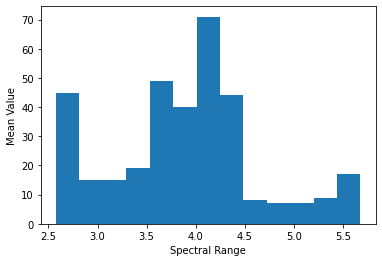

In [57]:
# Check and Plot the mean of each column

Q1 = np.percentile(means, 25, interpolation = 'midpoint')
Q3 = np.percentile(means, 75, interpolation = 'midpoint')
# Interquaritle range (IQR)
IQR = Q3 - Q1
bin_width = (2*(IQR)/(len(means)**(1/3)))
bins = round((max(means) - min(means))/bin_width)
# This method is taken from 
#https://stats.stackexchange.com/questions/143438/optimal-number-of-bins-in-histogram-by-the-freedman-diaconis-rule-difference-be
print("Freedman–Diaconis number of bins:", bins)
plt.hist(means, bins = bins);
plt.xlabel('Spectral Range')
plt.ylabel('Mean Value')

In [58]:
# List out the Top 20 Correlated Features with the Target
c = df.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort")

print (so[-367:-347])
# we can see from the output that we have multi-colinearity in the dataset

1312  1314    0.999997
1314  1312    0.999997
1310  1308    0.999997
1308  1310    0.999997
1472  1470    0.999997
1470  1472    0.999997
1312  1310    0.999998
1310  1312    0.999998
1480  1478    0.999998
1478  1480    0.999998
      1476    0.999998
1476  1478    0.999998
1454  1452    0.999998
1452  1454    0.999998
1474  1476    0.999998
1476  1474    0.999998
1474  1472    0.999998
1472  1474    0.999998
1450  1452    0.999999
1452  1450    0.999999
dtype: float64


In [59]:
# Remove Multi-Colinearity
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (((corr_matrix.iloc[i, j] >= threshold) or 
                 (corr_matrix.iloc[i,j]<=-threshold)) and 
                (corr_matrix.columns[j] not in col_corr)):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
            

    print(dataset)
    return(dataset)

filtered_df = correlation(df,0.9999) # TBD - Experiment with the data

     ContentUniformity      1110      1112  ...      1796      1798      1800
0                100.1  2.659006  2.672815  ...  3.903085  3.792994  3.794084
1                 99.4  2.633610  2.647536  ...  3.886848  3.784373  3.770951
2                100.7  2.692640  2.706064  ...  3.923675  3.811084  3.817034
3                100.0  2.712384  2.727113  ...  4.122222  3.958862  3.963222
4                 99.7  2.588002  2.597217  ...  3.908645  3.875009  3.850762
..                 ...       ...       ...  ...       ...       ...       ...
170               97.8  2.903835  2.922184  ...  4.345699  4.214854  4.181906
171               96.4  2.625422  2.638023  ...  3.843260  3.777243  3.753384
172               97.0  2.694591  2.706141  ...  3.932312  3.806685  3.794307
173               97.9  2.644989  2.658219  ...  3.851602  3.773104  3.756400
174               97.7  2.674914  2.690179  ...  3.890528  3.791181  3.781098

[175 rows x 213 columns]


In [60]:
cor = filtered_df.corr()
#Correlation with output variable
cor_target = abs(cor["ContentUniformity"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

ContentUniformity    1.000000
1118                 0.515035
1120                 0.541604
1122                 0.567931
1124                 0.592149
                       ...   
1682                 0.580350
1684                 0.570007
1686                 0.552562
1688                 0.525651
1690                 0.505358
Name: ContentUniformity, Length: 88, dtype: float64

In [61]:
columns = list(df.columns)

# Model Training

In [62]:
train_dataset = filtered_df.sample(frac=0.8, random_state=0)
test_dataset = filtered_df.drop(train_dataset.index)
#train_dataset = df.sample(frac=0.8, random_state=0)
#test_dataset = df.drop(train_dataset.index)

In [63]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('ContentUniformity')
test_labels = test_features.pop('ContentUniformity')

In [64]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

## Baseline Model Training

In [65]:
# Baseline Solution taken from experience 
# as I have worked on a similar dataset
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(256, activation='relu'),
      layers.Dense(128, activation='swish'),
      layers.Dense(16, activation='swish'),
      layers.Dense(8, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_percentage_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [66]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 212)               425       
_________________________________________________________________
dense_6 (Dense)              (None, 256)               54528     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 90,058
Trainable params: 89,633
Non-trainable params: 425
________________________________________________

In [67]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
4/4 [==============================] - 1s 114ms/step - loss: 99.4629 - val_loss: 98.1615
Epoch 2/100
4/4 [==============================] - 0s 9ms/step - loss: 97.7499 - val_loss: 95.5941
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 94.8849 - val_loss: 91.1641
Epoch 4/100
4/4 [==============================] - 0s 9ms/step - loss: 90.1554 - val_loss: 84.0088
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 82.8569 - val_loss: 72.9425
Epoch 6/100
4/4 [==============================] - 0s 10ms/step - loss: 70.9944 - val_loss: 58.4605
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 57.3901 - val_loss: 48.4723
Epoch 8/100
4/4 [==============================] - 0s 9ms/step - loss: 51.2689 - val_loss: 48.2791
Epoch 9/100
4/4 [==============================] - 0s 9ms/step - loss: 50.5934 - val_loss: 48.6223
Epoch 10/100
4/4 [==============================] - 0s 15ms/step - loss: 49.7919 - val_loss: 45.1730
Ep

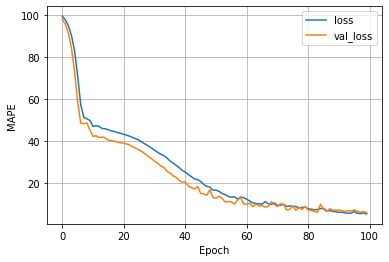

In [68]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('MAPE')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [69]:
# Minimum Validation MAPE
print(min(history.history['val_loss']))

5.931873798370361


In [70]:
test_results = {}
test_results['baseline_model'] = dnn_model.evaluate(test_features, test_labels, verbose=1)

2/2 [==============================] - 0s 7ms/step - loss: 8.2651


In [71]:
test_results

{'baseline_model': 8.265131950378418}

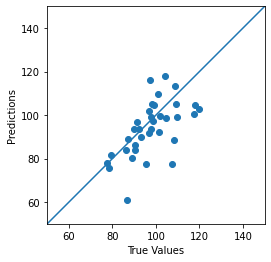

In [72]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [50, 150]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## HyperParamter Tuned Model

In [73]:
## We will be using Keras Tuner to optimize the model
def model_builder(hp):
  model = keras.Sequential([normalizer])

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 8-256
  for i in range(hp.Int('num_layers', 2, 10)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value=256,
                                            step=32),
                               activation='relu'))
  model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  model.compile(
    optimizer=keras.optimizers.Adam(
    hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
    loss='mean_absolute_percentage_error',
    metrics=['mean_absolute_percentage_error'])

  return model

In [74]:
tuner = RandomSearch(model_builder,
                     objective='val_loss',
                     max_trials=5,
                     executions_per_trial=3,
                     project_name='HP_Tuner')

In [75]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 32, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [76]:
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.2, random_state=0)

In [77]:
tuner.search(X_train, y_train,
             epochs=100,
             validation_data=(X_test, y_test))

Trial 5 Complete [00h 00m 27s]
val_loss: 2.41696834564209

Best val_loss So Far: 2.41696834564209
Total elapsed time: 00h 02m 21s
INFO:tensorflow:Oracle triggered exit


In [78]:
tuner.results_summary()

Results summary
Results in ./HP_Tuner
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
num_layers: 9
units_0: 104
units_1: 8
learning_rate: 0.01
units_2: 232
units_3: 136
units_4: 136
units_5: 168
units_6: 168
units_7: 104
units_8: 136
Score: 2.41696834564209
Trial summary
Hyperparameters:
num_layers: 6
units_0: 136
units_1: 72
learning_rate: 0.01
units_2: 104
units_3: 200
units_4: 168
units_5: 232
units_6: 72
units_7: 8
Score: 3.769275188446045
Trial summary
Hyperparameters:
num_layers: 9
units_0: 104
units_1: 168
learning_rate: 0.001
units_2: 72
units_3: 200
units_4: 40
units_5: 200
units_6: 168
units_7: 72
units_8: 8
Score: 5.075222969055176
Trial summary
Hyperparameters:
num_layers: 2
units_0: 200
units_1: 40
learning_rate: 0.001
Score: 15.484692573547363
Trial summary
Hyperparameters:
num_layers: 8
units_0: 200
units_1: 72
learning_rate: 0.001
units_2: 8
units_3: 8
units_4: 8
units_5: 8
units_6: 8
units_7: 8
Score: 15.69024562835693

In [79]:
optimal_model=tuner.get_best_models(num_models=1)[0]

In [80]:
%%time
optimal_history = optimal_model.fit(X_train,y_train, epochs=100, 
                                    validation_data=(X_test,y_test))

Epoch 1/100
4/4 [==============================] - 1s 123ms/step - loss: 2.1142 - mean_absolute_percentage_error: 2.1142 - val_loss: 3.0753 - val_mean_absolute_percentage_error: 3.0753
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 2.3298 - mean_absolute_percentage_error: 2.3298 - val_loss: 3.1126 - val_mean_absolute_percentage_error: 3.1126
Epoch 3/100
4/4 [==============================] - 0s 11ms/step - loss: 2.2625 - mean_absolute_percentage_error: 2.2625 - val_loss: 2.1002 - val_mean_absolute_percentage_error: 2.1002
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 2.2316 - mean_absolute_percentage_error: 2.2316 - val_loss: 3.4933 - val_mean_absolute_percentage_error: 3.4933
Epoch 5/100
4/4 [==============================] - 0s 12ms/step - loss: 2.3198 - mean_absolute_percentage_error: 2.3198 - val_loss: 2.7597 - val_mean_absolute_percentage_error: 2.7597
Epoch 6/100
4/4 [==============================] - 0s 12ms/step - loss: 2.1150 

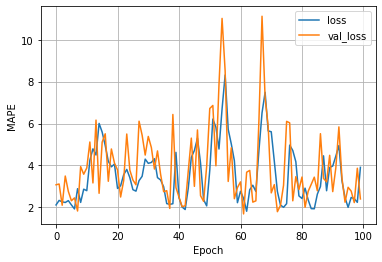

In [81]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('MAPE')
  plt.legend()
  plt.grid(True)
  
plot_loss(optimal_history)

In [82]:
# Minimum Validation MAPE
print(min(optimal_history.history['val_loss']))

1.685780644416809


In [83]:
test_results['optimal_model'] = optimal_model.evaluate(test_features, test_labels, verbose=1)
test_results

2/2 [==============================] - 0s 8ms/step - loss: 2.2762 - mean_absolute_percentage_error: 2.2762


{'baseline_model': 8.265131950378418,
 'optimal_model': [2.276172637939453, 2.276172637939453]}

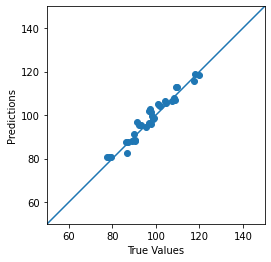

In [84]:
test_predictions = optimal_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [50, 150]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)